# Additional ReDeeM filtering
---

**Author:** Chen Weng

**Date:** Aug 13, 2024

## Description
A tutorial for  a quick start to use additional RedeeM filtering strategies <br/>
Including edge trimming, binomial modeling, etc


---

# Install redeem R package

In [16]:
# install the up-to-date R package
# devtools::install_github("chenweng1991/redeemR")
library(redeemR)
library(stringr)

## Step1. Preprocessing using standard redeemV

After preprocessing using standard [redeemV](https://github.com/chenweng1991/redeemV), We first load the preprocessed data. A typical result folder after redeemV should at least includes the following files to enable
```bash
├── QualifiedTotalCts
├── RawGenotypes.Sensitive.StrandBalance
├── RawGenotypes.Specific.StrandBalance
├── RawGenotypes.Total.StrandBalance
└── RawGenotypes.VerySensitive.StrandBalance
```

To reproduce this tutorial, skipping the full preprocessing steps, please directly download 
From the preprocessed data and decompress here https://doi.org/10.6084/m9.figshare.24418966.v1

## Step2. read redeemR data with edge trimming 

Here we use **Young1.T1.HSC.Consensus.final/** as an example </br>


In [11]:
## Define the directory to the example final. Replace by actual path
redeemv_final="/lab/solexa_weissman/cweng/Packages/redeemR/example_data/Young1.T1.HSC.Consensus.final/"

Use the updated function **redeemR.read.trim** to read the data and get VariantsGTSummary (variant genotype summary)
to run this tutorial, keep the parameter as follows. edge_trim is a new parameter that trim n bp from the fragment end.
- path: the path to the folder above
- Processed: F  otherwise, it will read in 
- thr: use S for this tutorial, for more information, check out the [Get_Started.ipynb](https://github.com/chenweng1991/redeemR/blob/master/Get_Started.ipynb)
- rdsname This will save out an rds object after generating the VariantsGTSummary
- edge_trim=5
We encourage fine-tuning the edge_trim. We have tested 4, 5, 9 and found trimming 4 or 5 can alreadly work reasonbly well.

It is normal to take 5-10 minutes to process the reading

In [17]:
VariantsGTSummary_trim5 <- redeemR.read.trim(path=redeemv_final, "S", Processed=F,
                                       rdsname="/VariantsGTSummary.S.trim5_binom.RDS",edge_trim=5)

By default only total depth is summarized

deprecated



[1] "Use all cells"
[1] "7257 Cells in QualifiedTotalCts"


Next, use **Create_redeemR_model** to process the additional filtering using binomial modeling, creat the redeemR object, 

In [21]:
redeemR_trim5_binom<-Create_redeemR_model(VariantsGTSummary_trim5)

Only heteroplasmic mutations are used

@Cts.Mtx and @Cts.Mtx.bi are added



Before cleaning up, worth to check the FDR and see what mutations are filtered out in this step.
- redeemR_trim5_binom@V.fitered </br>
This dataframe can be used to generate cellN versus PositiveMean_cts plot and can used to chat other metrics for each vartiant

Next, use **clean_redeem** to Clean up the redeem object by filtering the mutations that does not pass fdr 0.05, also remove a few hotspot mutations

In [24]:
redeemR_trim5_binom<- clean_redeem(redeemR_trim5_binom,fdr = 0.05)
redeemR_trim5_binom<-clean_redeem_removehot(redeemR_trim5_binom)

Only heteroplasmic mutations are used

@Cts.Mtx and @Cts.Mtx.bi are added

Only heteroplasmic mutations are used

@Cts.Mtx and @Cts.Mtx.bi are added



Next, use **add_raw_fragment** we add the raw mutation on fragment information, including the distance on fragment. This is useful to examine the mutations position biases, etc. 

In [36]:
redeemR_trim5_binom<- add_raw_fragment(redeemR_trim5_binom,raw="RawGenotypes.Sensitive.StrandBalance")

[1] "It has benn edge trimmed by 5 bp"


Run the following qc which will generate
- (histogram of 2) mutation position relative to fragment to examine potential position biases (1+ molecue are all the molecules >=1,  and 1-molecule is 1-molecule mutation only)
- (numbers) mutational signature, shown as transversion proportion: unweighted, weighted_freq_all, weight_freq_1mol,weight_freq_2mol,weight_freq_3mol) 
- metrics of cell number, mutation number, mutation per cell, , number of mutations connected, and the largest subgraph
- (scatter plot) Each dot is avariant, showing the number (x axis) of cell verses the count measurement(y axis)

[1] "Make sure add_raw_fragment has been run  after clean_redeem"


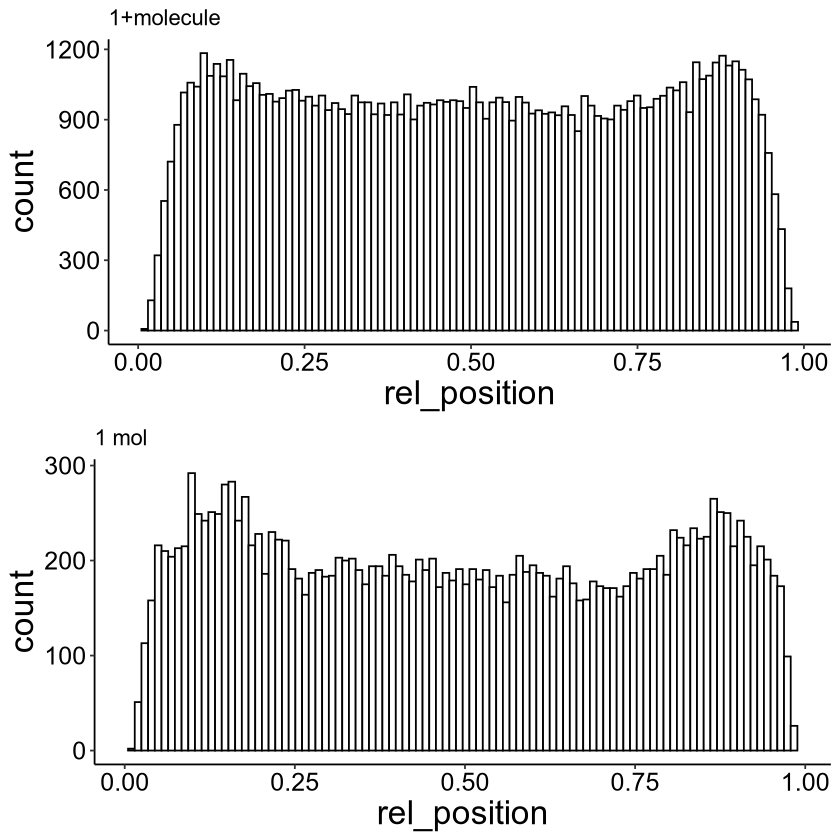

            unweight      weight_freq_all     weight_freq_1mol 
          0.05035605           0.03098356           0.02974475 
    weight_freq_2mol weight_freq_3molplus 
          0.04265842           0.03078950 
[1] "number of cells: 5937"
[1] "number of total mutations: 3932"
[1] "number of mutations per cell: 4"
[1] "number of cells connected: 39"
[1] "fraction of cells in component: 0.999663129526697"


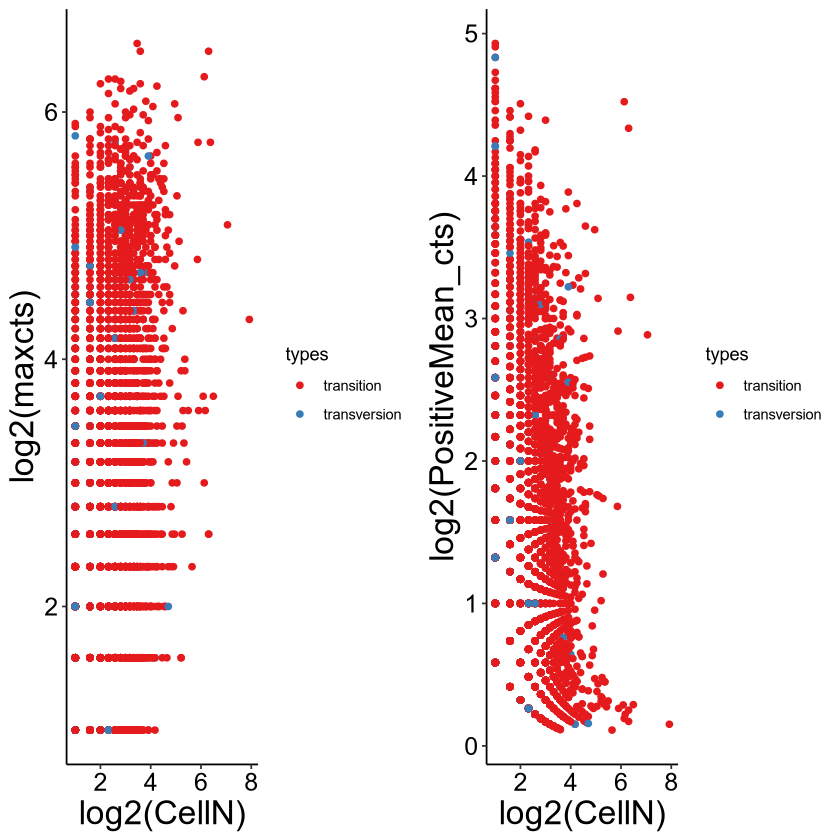

In [38]:
qc_report<-run_redeem_qc(redeemR_trim5_binom, redeemR_trim5_binom@HomoVariants)

The analyzed qc report output the following two measurement that is worth to check
- qc_report$report_metric 

- qc_report$transversion_rate

Key data generated that worth check out
- redeemR_trim5_binom@raw.fragment.uniqV   This stores the key raw molecue information for QC
- redeemR_trim5_binom@Cts.Mtx and redeemR_trim5_binom@Cts.Mtx bi are the matrix after edge trimming and binomial modeling

The generated redeemR object is compatible for other analysis, including ones1 described earlier [Get_Started.ipynb](https://github.com/chenweng1991/redeemR/blob/master/Get_Started.ipynb)

We provide a convinient function to provide a one line preprocessing

In [49]:
preprocessed_redeemr_trim5_binom <- function(redeemv_final, qcreport=T){
    VariantsGTSummary <- redeemR.read.trim(redeemv_final,sample, "S", Processed=T,
                                       "/VariantsGTSummary.S.trim5_binom.RDS",edge_trim=5)
    redeemR<-Create_redeemR_model(VariantsGTSummary)
    redeemR<- clean_redeem(redeemR,fdr = 0.05)
    redeemR<-clean_redeem_removehot(redeemR)
    redeemR<- add_raw_fragment(redeemR,raw="RawGenotypes.Sensitive.StrandBalance")
    report<-run_redeem_qc(redeemR, redeemR@HomoVariants)
    if (qcreport){
        return(list(redeemR=redeemR,report=report))
    }else{
        return(redeemR)
    }    
}

In [ ]:
redeem_trim5_binom<-preprocessed_redeemr_trim5_binom(WD)